<a href="https://colab.research.google.com/github/moncykurien/MalignantCommentsClassifier/blob/main/MalignantCommentsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.externals import joblib


In [ ]:
from wordcloud import WordCloud,STOPWORDS
import string
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import sys

In [ ]:
#Download spaCy's en Model
!{sys.executable} -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import spacy
from nltk.tokenize import word_tokenize

#Loading train and test data

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [ ]:
train_data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
print(f'In Train dataset, there are {train_data.shape[0]} rows and {train_data.shape[1]} columns.')
print(f'In Test dataset, there are {test_data.shape[0]} rows and {test_data.shape[1]} columns.')

In Train dataset, there are 159571 rows and 8 columns.
In Test dataset, there are 153164 rows and 2 columns.


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Observations:
1. The target variables are binary.

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
print(f"The columns in the train set are: {train_data.columns.values}")
print(f"The columns in the test set are: {test_data.columns.values}")

The columns in the train set are: ['id' 'comment_text' 'malignant' 'highly_malignant' 'rude' 'threat'
 'abuse' 'loathe']
The columns in the test set are: ['id' 'comment_text']


In [ ]:
#Takgin the target variable column names
target_cols = ['malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe']

#Data Visualization

##Visualizing each target variables

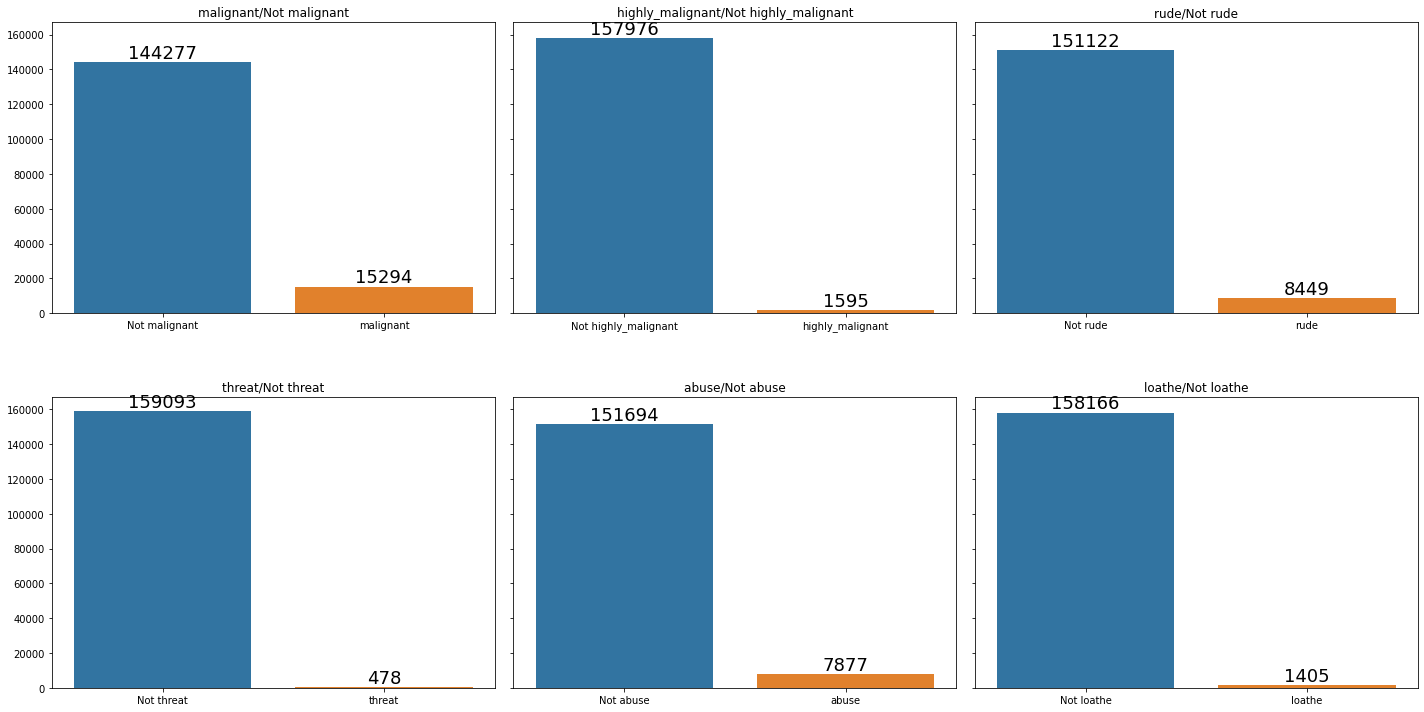

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)

i = -1
j = 0
for col in target_cols:
  plt.tight_layout(h_pad=5.0)
  
  if j % 3 == 0:
    i+=1
    j = 0
    ax=sns.barplot(['Not '+col,col], train_data[col].value_counts().values, ax=axes[i,j])
  else:
    ax=sns.barplot(['Not '+col,col], train_data[col].value_counts().values, ax=axes[i,j])

  #adding the text labels
  rects = ax.patches
  labels = train_data[col].value_counts().values
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
  axes[i,j].set_title(col+'/Not '+col)
  j += 1

Observations:
1. The plots shows that the train dataset containes large number of samples that are not toxic than the samples for any of the types of toxic.

##Correlation between the target variables.

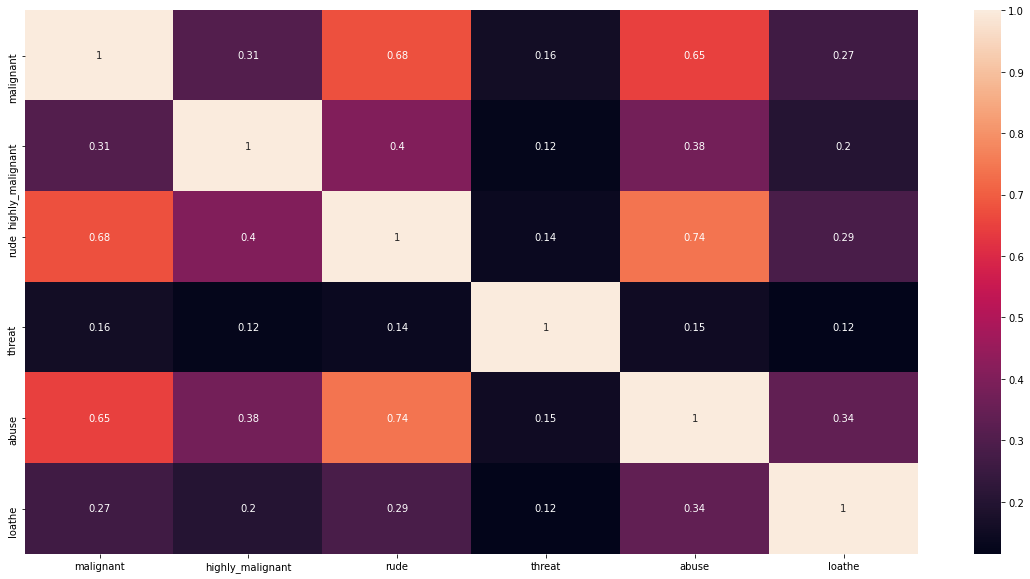

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(train_data.corr(),annot = True)

Observations:
1. The 'rude' and 'abuse' target variables have slightly strong positive correlation with each other with 0.74.
2. 'malignant' and 'rude' have positive correlation with each other.
3. 'malignant has a positive correlaton with 'abuse' also.

#Feature Engineering

##Getting the toxicity in each comment based on number of active target variables

In [ ]:
train_data['num_of_toxic_words_in_comment'] = train_data.loc[:,target_cols].sum(axis = 1)

In [ ]:
toxic_comments_data = train_data[train_data['num_of_toxic_words_in_comment'] > 0]
non_toxic_comments_data = train_data[train_data['num_of_toxic_words_in_comment'] == 0]

In [ ]:
toxic_comments_data

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,num_of_toxic_words_in_comment
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,2


In [ ]:
non_toxic_comments_data

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,num_of_toxic_words_in_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


###Visualizing the count of toxicity of the comments

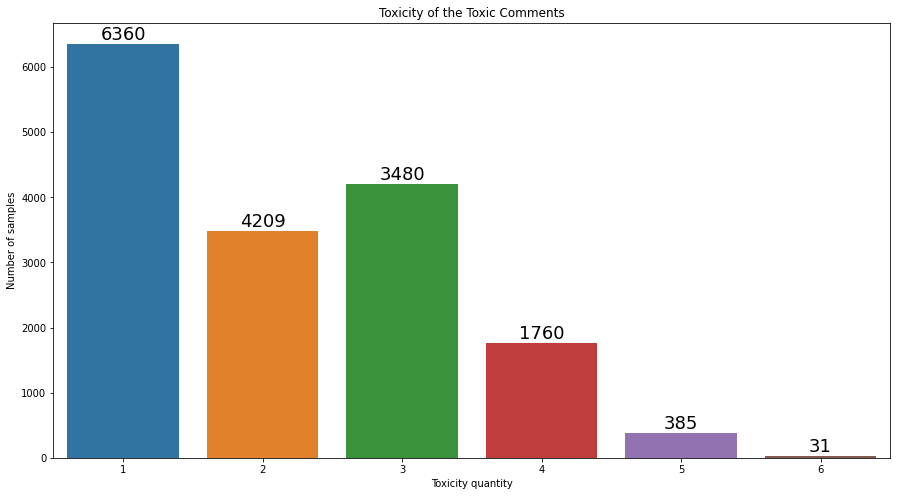


There are 6360 comments which have 1 type(s) of toxicity.
There are 4209 comments which have 2 type(s) of toxicity.
There are 3480 comments which have 3 type(s) of toxicity.
There are 1760 comments which have 4 type(s) of toxicity.
There are 385 comments which have 5 type(s) of toxicity.
There are 31 comments which have 6 type(s) of toxicity.
There are 143346 non toxic comments in the train data.


In [ ]:
plt.figure(figsize=(15,8))
plt.title('Toxicity of the Toxic Comments')
ax = sns.barplot(toxic_comments_data['num_of_toxic_words_in_comment'].value_counts().index,toxic_comments_data['num_of_toxic_words_in_comment'].value_counts().values)
plt.xlabel("Toxicity quantity")
plt.ylabel("Number of samples")

#adding the text labels
rects = ax.patches
labels = toxic_comments_data['num_of_toxic_words_in_comment'].value_counts().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()
print()
for i in range(toxic_comments_data['num_of_toxic_words_in_comment'].value_counts().shape[0]):
  print(f"There are {toxic_comments_data['num_of_toxic_words_in_comment'].value_counts().values[i]} comments which have {i+1} type(s) of toxicity.")
print(f"There are {non_toxic_comments_data.shape[0]} non toxic comments in the train data.")

Observations:
1. About 6360 comments/samples have only one type of toxicity. Which means these many data points have only one label associated to them.
2. About 4209 data points have 2 labels associated to them.
3. About 3480 data points have 3 labels associated to them.
4. About 1760 data points have 4 labels associated to them.
5. About 385 data points have 5 labels associated to them.
6. About 31 data points have 6 labels associated to them.
7. About 143346 data points have no labels associated to them.

###Visualizing target variables against each other

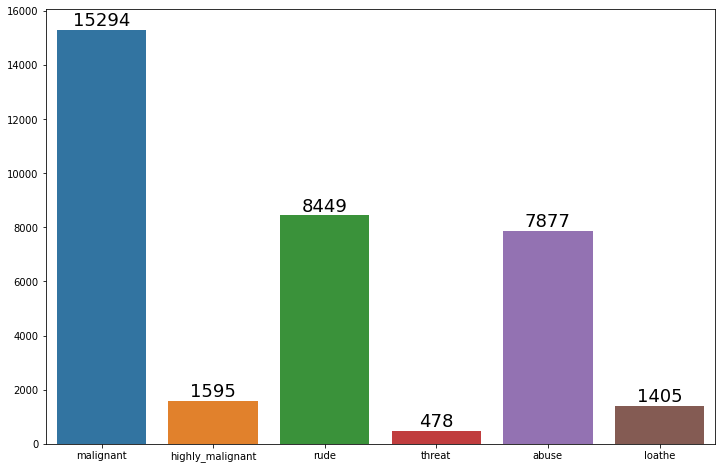

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(train_data[target_cols].sum().index,train_data[target_cols].sum().values)

#adding the text labels
rects = ax.patches
labels = train_data[target_cols].sum().values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

Observations:
1. There are 6360 samples in the train dataset with only 1 type of toxicity.
2. There are 4209 samples in the train dataset with 2 types of toxicities.
3. There are 3480 samples in the train dataset with 3 types of toxicities.
4. There are 1760 samples in the train dataset with 4 types of toxicities.
5. There are 385 samples in the train dataset with 5 types of toxicities.
6. There are only 31 samples in which all 6 types of toxicities are labeled.
7. There are 143346 non toxic comments in the train data.

##Feature Engineering the number of comments that have only one toxicity.

In [ ]:
for col in target_cols:
  train_data['only_'+col] = np.where((train_data[col] == 1) & (train_data.loc[:, target_cols].sum(axis = 1) == 1),1,0)

###Visualizing the number of comments that has only one target variable set as 1

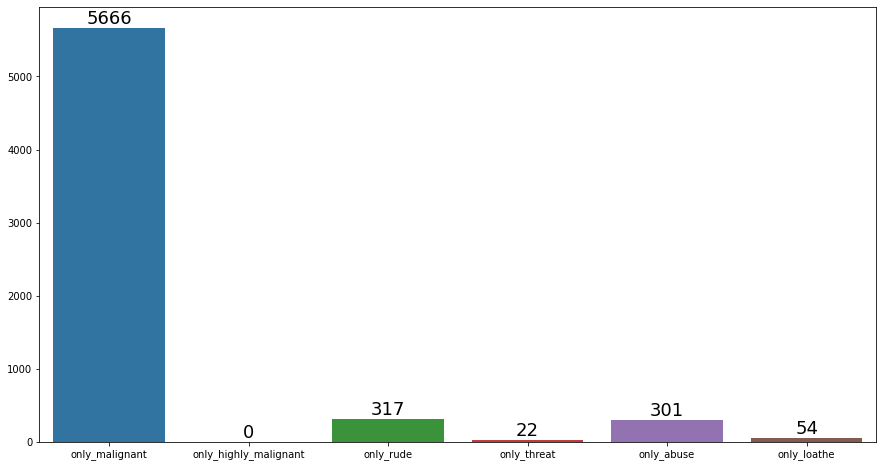


Toxicity	Number of Samples in train dataset

========	==================================
only_malignant           5666
only_highly_malignant       0
only_rude                 317
only_threat                22
only_abuse                301
only_loathe                54
dtype: int64


In [ ]:
exclusive_toxics = ['only_malignant',
       'only_highly_malignant', 'only_rude', 'only_threat', 'only_abuse',
       'only_loathe']
plt.figure(figsize=(15,8))
ax = sns.barplot(train_data[exclusive_toxics].sum().index, train_data[exclusive_toxics].sum().values)

#adding the text labels
rects = ax.patches
labels = train_data[exclusive_toxics].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)


plt.show()
print("\nToxicity\tNumber of Samples in train dataset")
print("\n"+"="*len('Toxicity')+"\t"+"="*len('Number of Samples in train dataset'))
print(train_data[exclusive_toxics].sum())

Observations:
1. There are 5666 comments in the train data that are associated to only malignant label.
2. There are no comments in the train data that is associated to only highly malignant label.
3. There are 317 comments in the train data that are associated to only rude label.
4. There are 22 comments in the train data that are associated to only threats label.
5. There are 301 comments in the train data that are associated to only abuses label.
6. There are 54 comments in the train data that are associated to only loathes label.

In [ ]:
print(f"There are {train_data[train_data['highly_malignant'] == 1].shape[0]} samples with highly malignant comments in which {train_data[train_data['highly_malignant'] == 1]['malignant'].sum()} samples are also malignant comments.")

There are 1595 samples with highly malignant comments in which 1595 samples are also malignant comments.


Observations:
1. We can see that all highly malignant comments are also malignant. That is why we are getting 0 comments that are only highly malignant.

##Getting the length of the comments

In [ ]:
train_data['comment_text_length'] = train_data['comment_text'].str.len()
train_data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_text_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


In [ ]:
test_data['comment_text_length'] = test_data['comment_text'].str.len()
test_data.head()

,id,comment_text,comment_text_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,00017563c3f7919a,":If you have a look back at the source, the in...",205
4,00017695ad8997eb,I don't anonymously edit articles at all.,41


##Cleaning the original comments

In [ ]:
def clean_text(dataframe, feature, new_feature):
  punctuations = string.punctuation
  additional_words = ['u','ur','im','doin','ure','i','so','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','and','i','a','and','so','arnt','this','when','it','many','many','so','cant','yes','no','these', 'daww','umm']
  stop_words = set(stopwords.words('english') + additional_words)

  def remove_stopwords_punct(x):
   cln = []
   for word in x.split():
     c = []
     for char in word:
       if char not in punctuations:
         c.append(char)
     if ''.join(c) not in stop_words:
       cln.append(''.join(c))
   return ' '.join(cln)

  def removePatterns(x): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',x)
    return (cleaned_text)

  #Converting all characters to lowercase
  dataframe[new_feature] = dataframe[feature].str.lower()

  #Replace any email addresses as "emailaddress"
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

  #Replace any web site addresses as "webaddress"
  dataframe[new_feature] = dataframe[new_feature].str.replace(r"^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$", 'webaddress')

  #Remove any html tags
  dataframe[new_feature] = dataframe[new_feature].str.replace(r"<.*?>", ' ')

  #Replace any currencies as 'currencyamount'
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'£|\$|₹','currencyamount')

  #Replace any phone numbers as "phonenumber"
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

  #Replace any numbers as "numbr"
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'\d+(\.\d+)?','numbr')

  #Removing punctuations and stopwords
  dataframe[new_feature] = dataframe[new_feature].apply(remove_stopwords_punct)
  
  #Removing any unneccessarily repeating characters
  dataframe[new_feature] = dataframe[new_feature].apply(removePatterns)

  #Replace any non alphabetic characters with a blank space
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'[^\w\d\s]',' ')

  #Replace any extra statuses with a single blank space
  dataframe[new_feature] = dataframe[new_feature].str.replace(r'\s+',' ')

In [ ]:
clean_text(train_data, 'comment_text', 'cleaned_comment_text')
train_data.isnull().sum()

id                      0
comment_text            0
malignant               0
highly_malignant        0
rude                    0
threat                  0
abuse                   0
loathe                  0
comment_text_length     0
cleaned_comment_text    0
dtype: int64

In [ ]:
clean_text(test_data, 'comment_text', 'cleaned_comment_text')
test_data.isnull().sum()

id                      0
comment_text            0
comment_text_length     0
cleaned_comment_text    0
dtype: int64

##Getting the lenghts of the cleaned comments

In [ ]:
train_data['cleaned_comment_text_length'] = train_data['cleaned_comment_text'].str.len()
train_data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_text_length,cleaned_comment_text,cleaned_comment_text_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,explanation edits made username hardcore metal...,184
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,matches background colour seemingly stuck than...,88
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,hey man really trying edit war guy constantly ...,141
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,make real suggestions improvement wondered se...,366
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,sir hero chance remember page thats,35


In [ ]:
test_data['cleaned_comment_text_length'] = test_data['cleaned_comment_text'].str.len()
test_data.head()

,id,comment_text,comment_text_length,cleaned_comment_text,cleaned_comment_text_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,yo bitch ja rule succesful youll ever whats ha...,248
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,rfc title fine imo,19
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,sources zawe ashton lapland,29
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,look back source information updated correct f...,115
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,dont anonymously edit articles,30


##Descriptive Analysis

In [ ]:
train_data.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,comment_text_length,cleaned_comment_text_length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,394.138847,252.322032
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,590.725381,392.299515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.000000,60.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,130.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,436.000000,276.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,5000.000000


Observations:
1. The malignant, highly_malignant, rude, threat, abuse and loathe are all binary variables.
2. The average number of toxic comments is 0.22 which indicates that there are only less data that are toxic comments.
3. On an average there are about 394 characters in the original comment texts in the train dataset. The smallest comment contains 5 characters and the biggest comment contains 5000 characters.
4. On an average there are about 252 characters in the original comment texts in the train dataset. The smallest comment contains 0 character meaning there are empty data in some of the cleaned comment texts now and the biggest comment is still 5000 characters long.
5. There are about 9.58% of malignant comments in the train data.
6. There are about 0.99% of highly malignant comments in the train data.
7. There are about 5.29% of rude comments in the train data.
8. There are about 0.3% of threat comments in the train data.
9. There are about 4.93% of abuse comments in the train data.
10. There are about 0.88% of loathe comments in the train data.

In [ ]:
test_data.describe()

,comment_text_length,cleaned_comment_text_length
count,153164.000000,153164.000000
mean,364.875121,233.101708
std,592.492099,408.863589
min,1.000000,0.000000
25%,79.000000,48.000000
50%,180.000000,112.000000
75%,392.000000,246.000000
max,5000.000000,12911.000000


In [ ]:
test_data[test_data['cleaned_comment_text_length']>5000]

,id,comment_text,comment_text_length,cleaned_comment_text,cleaned_comment_text_length
15450,19fdaf82090bd58a,با عرض سلام خدمت هيئت اعضاي سازمان ملل و حقوق ...,4986,با عرض سلام خدمت هيئت اعضاي سازمان ملل و حقوق ...,5002
22019,24c1c192501b9fad,== C0pyr1ght 15 5h1t fb1 5uck5 4 5hut d0wn s1...,4907,cnumbrpyrnumbrght numbr numbrhnumbrt fbnumbr ...,9061
46056,4c6c3f0cefb99a8c,==Liber Dalminium== \n\n Liber dalminium is ne...,4819,liber dalminium liber dalminium neopagan text ...,5101
55276,5bf95668035f5976,== PHCK U A$$HOLE PHCK U A$$HOLE PHCK U A$$HOL...,2369,phck acurrencyamountcurrencyamounthole phck a...,6128
56506,5e045f47185d5901,Hacked by m1ckHacked by m1ckHacked by m1ckHack...,5000,hacked mnumbrckhacked mnumbrckhacked mnumbrckh...,5357
76422,7f6c9b906748a6d4,== YA ALLAH XUDAYA BYTYN DYNYA HÖKMƏTLƏRİNƏ Aİ...,4976,ya allah xudaya bytyn dynya hökmətləri nə ai ...,5093
103144,ac2f01ef37013e7d,B00LL00X B00LL00X B00LL00X B00LL00X B00LL00X B...,5000,bnumbrllnumbrx bnumbrllnumbrx bnumbrllnumbrx b...,8333
122054,cbd77f266975f6ae,KISS MY ASS BITCHHHHHHHHHHHHHHHHHHHHHHHHHHHHH ...,4993,kiss ass trevor thorpe numbrnumbrnumbrnumbr tr...,5983
133378,def8da1531a2bf2c,TEL AVIV MOI OUMOUADENE ABDELKADER DATE DE NA...,4991,tel aviv moi oumouadene abdelkader date de nai...,5090
147166,f602f055b40df07f,"""I HAVE A LARGE WEINER \n\n \n\n \n AUISCBB...",3942,large weiner auiscbbqwcvbiwcb qwqwp idhjqpwiod...,6635


##Visualizing the words that support each target variable.

###Word cloud of Malignant comments

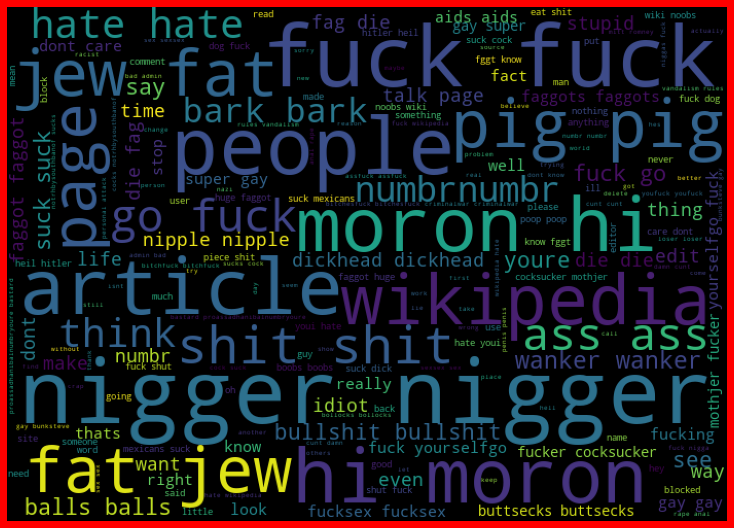

In [ ]:
malignant = train_data[train_data['malignant']==1]['cleaned_comment_text']

malignant_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(malignant))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(malignant_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of Highly malignant comments

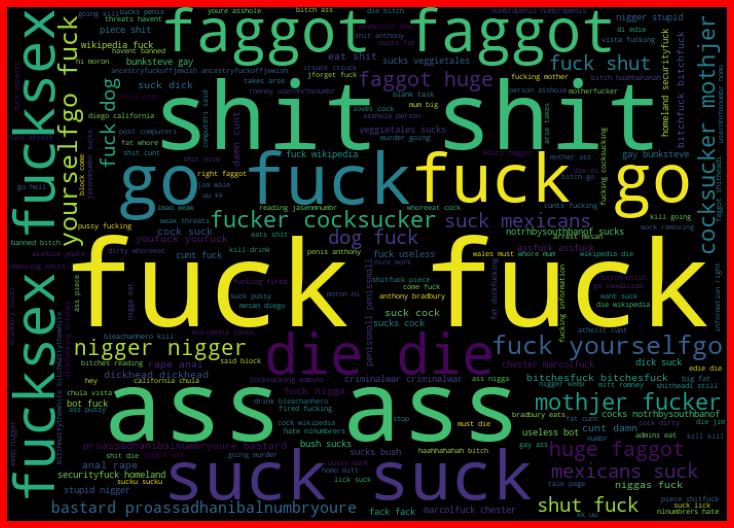

In [ ]:
highly_malignant = train_data[train_data['highly_malignant']==1]['cleaned_comment_text']

highly_malignant_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(highly_malignant))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(highly_malignant_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of rude comments

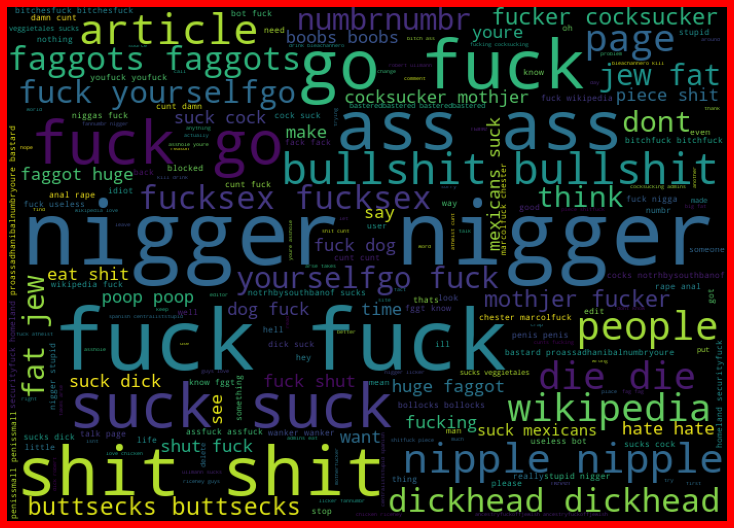

In [ ]:
rude = train_data[train_data['rude']==1]['cleaned_comment_text']

rude_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(rude))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(rude_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of Threat comments

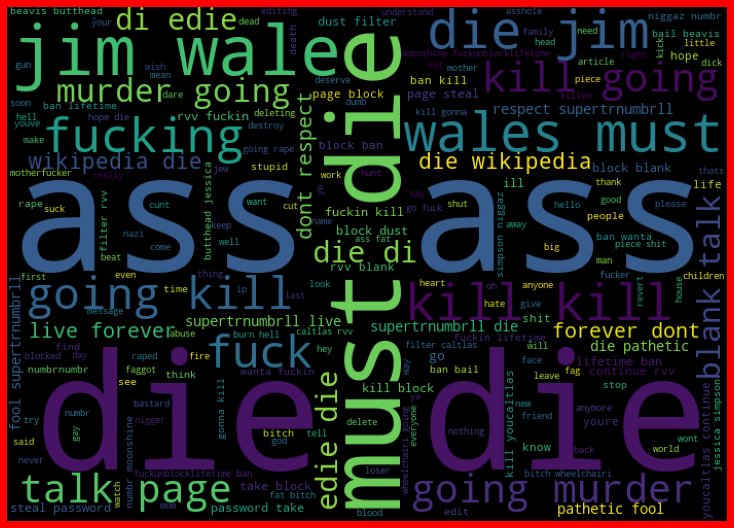

In [ ]:
threat = train_data[train_data['threat']==1]['cleaned_comment_text']

threat_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(threat))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(threat_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of abuse comments

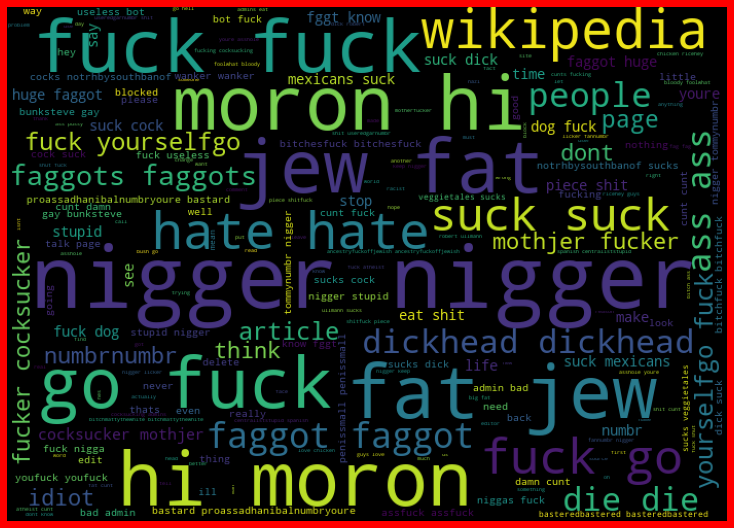

In [ ]:
abuse = train_data[train_data['abuse']==1]['cleaned_comment_text']

abuse_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(abuse))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(abuse_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of loathe comments

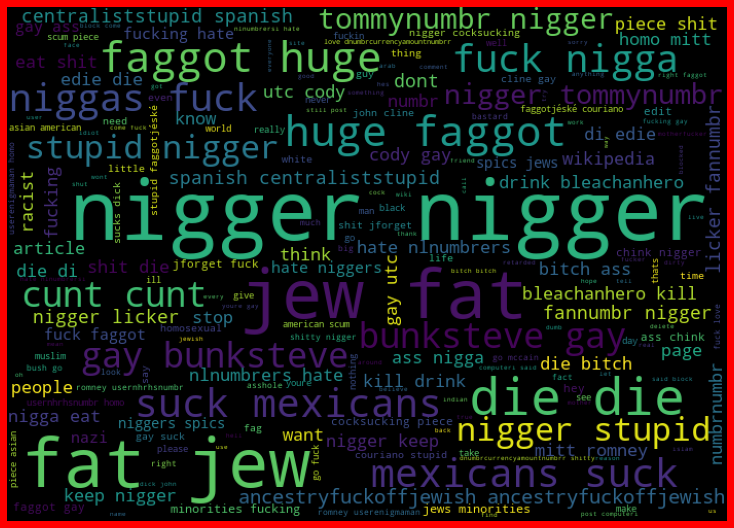

In [ ]:
loathe = train_data[train_data['loathe']==1]['cleaned_comment_text']

loathe_cloud = WordCloud(width=700,height=500,background_color='black').generate(' '.join(loathe))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(loathe_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

###Word cloud of clean comments

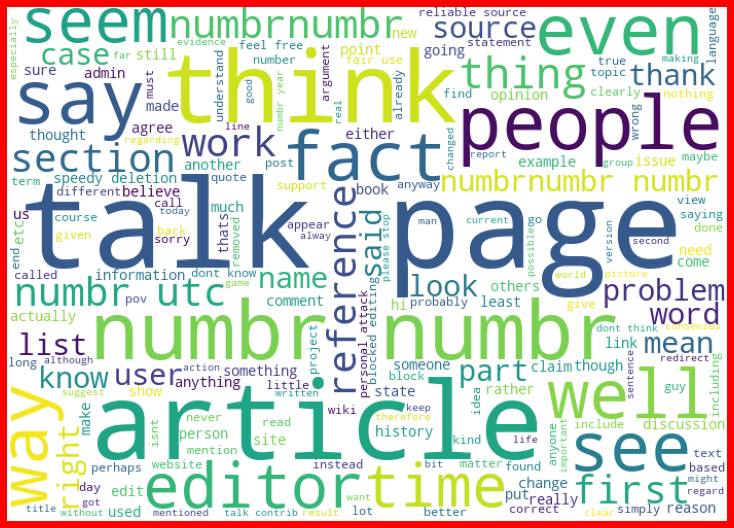

In [ ]:
clean = train_data[train_data['num_of_toxic_words_in_comment']==0].cleaned_comment_text.values

clean_cloud = WordCloud(stopwords=STOPWORDS,width=700,height=500,background_color='white').generate(' '.join(clean))

plt.figure(figsize=(10,8), facecolor='r')
plt.imshow(clean_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Saving without lemmatizing for Google Word2Vec model

In [ ]:
train_data[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe','cleaned_comment_text','num_of_toxic_words_in_comment']].to_csv('/content/cleaned_train_data_for_W2V.csv', sep = ',')

#Lemmatization

Using Spacy to Lemmatize the cleaned comments

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])
train_data['lemmatized_clean_comment_text'] = train_data['cleaned_comment_text'].apply(lambda comment: ' '.join([token.lemma_ for token in nlp(comment)]))

train_data.isnull().sum()

id                               0
comment_text                     0
malignant                        0
highly_malignant                 0
rude                             0
threat                           0
abuse                            0
loathe                           0
comment_text_length              0
cleaned_comment_text             0
cleaned_comment_text_length      0
lemmatized_clean_comment_text    0
dtype: int64

In [ ]:
train_data['lemmatized_clean_comment_text'].isnull().sum()

0

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])
test_data['lemmatized_clean_comment_text'] = test_data['cleaned_comment_text'].apply(lambda comment: ' '.join([token.lemma_ for token in nlp(comment)]))

test_data.isnull().sum()

id                               0
comment_text                     0
comment_text_length              0
cleaned_comment_text             0
cleaned_comment_text_length      0
lemmatized_clean_comment_text    0
dtype: int64

In [ ]:
test_data['lemmatized_clean_comment_text'].isnull().sum()

0

Saving the cleaned and lemmatized data

In [ ]:
train_data[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe','lemmatized_clean_comment_text','num_of_toxic_words_in_comment']].to_csv('/content/cleaned_lemmatized_train_data.csv', sep = ',')

In [ ]:
test_data[['lemmatized_clean_comment_text']].to_csv('/content/cleaned_lemmatized_test_data.csv', sep = ',')

#Vectorizing the dataset and testing models

Loading the saved cleaned and lemmatized data

In [ ]:
dataset = pd.read_csv('/content/cleaned_lemmatized_train_data.csv')
test_dataset = pd.read_csv('/content/cleaned_lemmatized_test_data.csv')

In [ ]:
dataset.isnull().sum()

Unnamed: 0                        0
malignant                         0
highly_malignant                  0
rude                              0
threat                            0
abuse                             0
loathe                            0
lemmatized_clean_comment_text    22
num_of_toxic_words_in_comment     0
dtype: int64

In [ ]:
test_dataset.isnull().sum()

Unnamed: 0                        0
lemmatized_clean_comment_text    48
dtype: int64

Observations:
1. For some reason, there are null values in the data when the data is saved as a csv and read again.

Investigating the null values

In [ ]:
train_data.iloc[dataset[dataset['lemmatized_clean_comment_text'].isnull()].index]

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_text_length,cleaned_comment_text,cleaned_comment_text_length,lemmatized_clean_comment_text
2407,067638a445ccd93b,"Here, here and here.",0,0,0,0,0,0,20,,0,
23095,3d09050e81205163,Where was it before?,0,0,0,0,0,0,20,,0,
31072,528b079a22ccbfb0,!!!!!\nWhat is all of this.,0,0,0,0,0,0,26,,0,
38313,664baa9268a34574,what \n\nwhy did you do that!!,0,0,0,0,0,0,28,,0,
39799,6a4619b36fbb27f1,"many, many, many, many, many}}",0,0,0,0,0,0,30,,0,
64304,ac14106a1572f89f,WHAT DID I D!!!!!!!!!!!!!!!!!!!!!O,0,0,0,0,0,0,34,,0,
71720,c006239fbff791e0,"No, they are not.",0,0,0,0,0,0,17,,0,
72130,c11645a80238d1b0,Yes I did that too,0,0,0,0,0,0,18,,0,
82232,dc05e79cd9a50e0d,have\n with them.,0,0,0,0,0,0,30,,0,
89363,ef0d6f9f6f836857,This is one of them.,0,0,0,0,0,0,20,,0,


In [ ]:
test_data.iloc[test_dataset[test_dataset['lemmatized_clean_comment_text'].isnull()].index]

,id,comment_text,comment_text_length,cleaned_comment_text,cleaned_comment_text_length,lemmatized_clean_comment_text
662,0118f7ea375be714,:Me too!,8,,0,
6533,0af7effe1fd4b873,',1,,0,
6892,0b9c557f7d1dceb5,::::::What? o,13,,0,
7453,0c850a0c2d45e8a7,(not me) -,12,,0,
7793,0d17511ba23467c6,Why is that? -,14,,0,
13685,1703649721d83a38,:::here. ;-),12,,0,
14328,180c84ccd7464e32,:::Is what?,11,,0,
35455,3aebe798855d5c66,I did.,6,,0,
38957,40a72433a84c742d,:: Me three.,12,,0,
43330,47c5ea066d4eb210,(This was also me ),20,,0,


In [ ]:
print(f"There are {train_data[train_data['cleaned_comment_text'] == ''].shape[0]} rows with blank 'cleaned_comment_text' in train sata")
print(f"There are {train_data[train_data['lemmatized_clean_comment_text'].isnull()].shape[0]} rows with blank 'lemmatized_cleaned_comment_text' in train data")

There are 22 rows with blank 'cleaned_comment_text' in train sata
There are 0 rows with blank 'lemmatized_cleaned_comment_text' in train data


In [ ]:
print(f"There are {test_data[test_data['cleaned_comment_text'] == ''].shape[0]} rows with blank 'cleaned_comment_text'in test data")
print(f"There are {test_data[test_data['lemmatized_clean_comment_text'].isnull()].shape[0]} rows with blank 'lemmatized_cleaned_comment_text'in test data")

There are 48 rows with blank 'cleaned_comment_text'in test data
There are 0 rows with blank 'lemmatized_cleaned_comment_text'in test data


Observations:
1. As we can see there are 22 rows with empty 'cleaned_comment_text' and 'lemmatized_clean_comment_text'. There are 48 rows with empty 'cleaned_comment_text' and 'lemmatized_clean_comment_text' in test data.
2. These empty values are causing the null values in the dataset when saved and read again.
3. There are empty rows in the test data or chances of such rows in any future comments after cleaning and lemmatizing. Hence I am going to fill the null values with empty characters.

In [ ]:
dataset.fillna('', inplace=True)
dataset.isnull().sum()

Unnamed: 0                       0
malignant                        0
highly_malignant                 0
rude                             0
threat                           0
abuse                            0
loathe                           0
lemmatized_clean_comment_text    0
num_of_toxic_words_in_comment    0
dtype: int64

In [ ]:
test_dataset.fillna('', inplace=True)
test_dataset.isnull().sum()

Unnamed: 0                       0
lemmatized_clean_comment_text    0
dtype: int64

In [ ]:
target_cols = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']

Splitting the train dataset into train and validation sets

In [ ]:
train_text, val_text = train_test_split(dataset, random_state=42, test_size=0.20, shuffle=True)

#OneVsRest

##OneVsRest and TFIDF with mono grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.841251


In [ ]:
print("Dimensions of train data X:",x_train.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_val.shape,"Y:",y_val.shape)

Dimensions of train data X: (127656, 14152) Y : (127656, 6)
Dimensions of test data X: (31915, 14152) Y: (31915, 6)


In [ ]:
models_performances = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Hamming loss","Micro-Precision","Micro Recall","Micro F1"])

###OVR + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
classifier1.fit(x_train, y_train)
predictions = classifier1.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-logistic regression', 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_val, predictions, average='weighted')
recall = recall_score(y_val, predictions, average='weighted')
f1 = f1_score(y_val, predictions, average='weighted')
 
print("\nWeighted-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8635124549584835
Hamming loss  0.03524988250039167

Micro-average quality numbers
Precision: 0.5136, Recall: 0.8668, F1-measure: 0.6450

Macro-average quality numbers
Precision: 0.3994, Recall: 0.8475, F1-measure: 0.5150

Weighted-average quality numbers
Precision: 0.5645, Recall: 0.8668, F1-measure: 0.6754

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.86      0.72      3056
           1       0.25      0.86      0.39       321
           2       0.66      0.89      0.76      1715
           3       0.15      0.84      0.26        74
           4       0.52      0.87      0.65      1614
           5       0.20      0.76      0.32       294

   micro avg       0.51      0.87      0.64      7074
   macro avg       0.40      0.85      0.52      7074
weighted avg       0.56      0.87      0.68      7074
 samples avg       0.06      0.08      0.07      7074

Time taken to run this cell : 0:00:12.398327


###OVR + SGDClassifier log loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'log',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sdg classifier - log loss', 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8537364875450415
Hamming loss  0.04266019113269622

Micro-average quality numbers
Precision: 0.4586, Recall: 0.8575, F1-measure: 0.5976

Macro-average quality numbers
Precision: 0.3639, Recall: 0.8626, F1-measure: 0.4717

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3056
           1       0.23      0.88      0.36       321
           2       0.64      0.88      0.74      1715
           3       0.08      0.88      0.14        74
           4       0.51      0.86      0.64      1614
           5       0.16      0.84      0.26       294

   micro avg       0.46      0.86      0.60      7074
   macro avg       0.36      0.86      0.47      7074
weighted avg       0.54      0.86      0.65      7074
 samples avg       0.05      0.08      0.06      7074

Time taken to run this cell : 0:00:03.491113


###OVR + SGDClassifier hinge loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - hinge loss', 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8575278082406392
Hamming loss  0.039740978641182305

Micro-average quality numbers
Precision: 0.4792, Recall: 0.8742, F1-measure: 0.6191

Macro-average quality numbers
Precision: 0.3755, Recall: 0.8706, F1-measure: 0.4860

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.85      0.72      3056
           1       0.21      0.89      0.34       321
           2       0.65      0.90      0.76      1715
           3       0.10      0.85      0.18        74
           4       0.51      0.89      0.65      1614
           5       0.16      0.84      0.27       294

   micro avg       0.48      0.87      0.62      7074
   macro avg       0.38      0.87      0.49      7074
weighted avg       0.56      0.87      0.67      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:03.374189


##OneVsRest with TFIDF 1-2 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:23.659058


In [ ]:
print("Dimensions of train data X:",x_train.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_val.shape,"Y:",y_val.shape)

Dimensions of train data X: (127656, 44022) Y : (127656, 6)
Dimensions of test data X: (31915, 44022) Y: (31915, 6)


###OVR + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
classifier1.fit(x_train, y_train)
predictions = classifier1.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-logistic regression', 'tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8744790850697164
Hamming loss  0.03134367329886678

Micro-average quality numbers
Precision: 0.5490, Recall: 0.8490, F1-measure: 0.6668

Macro-average quality numbers
Precision: 0.4291, Recall: 0.8261, F1-measure: 0.5397

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      3056
           1       0.27      0.84      0.41       321
           2       0.69      0.87      0.77      1715
           3       0.19      0.81      0.30        74
           4       0.56      0.85      0.67      1614
           5       0.23      0.73      0.35       294

   micro avg       0.55      0.85      0.67      7074
   macro avg       0.43      0.83      0.54      7074
weighted avg       0.59      0.85      0.69      7074
 samples avg       0.06      0.08      0.07      7074

Time taken to run this cell : 0:00:19.709834


###OVR + SGDClassifier log loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'log',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - log loss', 'tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8577471408428639
Hamming loss  0.040299754556373704

Micro-average quality numbers
Precision: 0.4744, Recall: 0.8438, F1-measure: 0.6074

Macro-average quality numbers
Precision: 0.3737, Recall: 0.8462, F1-measure: 0.4812

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      3056
           1       0.24      0.88      0.38       321
           2       0.64      0.86      0.74      1715
           3       0.09      0.85      0.17        74
           4       0.51      0.85      0.64      1614
           5       0.17      0.81      0.28       294

   micro avg       0.47      0.84      0.61      7074
   macro avg       0.37      0.85      0.48      7074
weighted avg       0.54      0.84      0.65      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:03.901631


###OVR + SGDClassifier hinge loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - hinge loss', 'tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8659877800407332
Hamming loss  0.03584521384928717

Micro-average quality numbers
Precision: 0.5088, Recall: 0.8610, F1-measure: 0.6396

Macro-average quality numbers
Precision: 0.3982, Recall: 0.8508, F1-measure: 0.5092

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      3056
           1       0.23      0.88      0.37       321
           2       0.67      0.89      0.77      1715
           3       0.15      0.82      0.25        74
           4       0.53      0.88      0.66      1614
           5       0.18      0.79      0.29       294

   micro avg       0.51      0.86      0.64      7074
   macro avg       0.40      0.85      0.51      7074
weighted avg       0.58      0.86      0.68      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:03.533741


##OneVsRest with TFIDF 1-3 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:51.089196


In [ ]:
print("Dimensions of train data X:",x_train.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_val.shape,"Y:",y_val.shape)

Dimensions of train data X: (127656, 52561) Y : (127656, 6)
Dimensions of test data X: (31915, 52561) Y: (31915, 6)


###OVR + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
classifier1.fit(x_train, y_train)
predictions = classifier1.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-logistic regression', 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.874416418611938
Hamming loss  0.031166118335161103

Micro-average quality numbers
Precision: 0.5509, Recall: 0.8466, F1-measure: 0.6674

Macro-average quality numbers
Precision: 0.4309, Recall: 0.8237, F1-measure: 0.5413

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      3056
           1       0.27      0.84      0.41       321
           2       0.69      0.87      0.77      1715
           3       0.19      0.81      0.31        74
           4       0.56      0.85      0.67      1614
           5       0.23      0.73      0.35       294

   micro avg       0.55      0.85      0.67      7074
   macro avg       0.43      0.82      0.54      7074
weighted avg       0.59      0.85      0.69      7074
 samples avg       0.06      0.08      0.07      7074

Time taken to run this cell : 0:00:22.310960


###OVR + SGDClassifier log loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'log',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - log loss', 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8572458091806361
Hamming loss  0.04004908872525981

Micro-average quality numbers
Precision: 0.4762, Recall: 0.8427, F1-measure: 0.6085

Macro-average quality numbers
Precision: 0.3749, Recall: 0.8440, F1-measure: 0.4829

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      3056
           1       0.24      0.87      0.38       321
           2       0.65      0.86      0.74      1715
           3       0.10      0.85      0.18        74
           4       0.51      0.85      0.64      1614
           5       0.17      0.80      0.28       294

   micro avg       0.48      0.84      0.61      7074
   macro avg       0.37      0.84      0.48      7074
weighted avg       0.54      0.84      0.65      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:04.042425


###OVR + SGDClassifier hinge loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - hinge loss', 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8650791164029453
Hamming loss  0.035537103765209674

Micro-average quality numbers
Precision: 0.5113, Recall: 0.8584, F1-measure: 0.6409

Macro-average quality numbers
Precision: 0.4005, Recall: 0.8483, F1-measure: 0.5118

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      3056
           1       0.24      0.88      0.37       321
           2       0.68      0.89      0.77      1715
           3       0.15      0.84      0.26        74
           4       0.53      0.87      0.66      1614
           5       0.18      0.78      0.30       294

   micro avg       0.51      0.86      0.64      7074
   macro avg       0.40      0.85      0.51      7074
weighted avg       0.57      0.86      0.68      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:03.866143


##OneVsRest with TFIDF 1-4 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:19.250793


In [ ]:
print("Dimensions of train data X:",x_train.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_val.shape,"Y:",y_val.shape)

Dimensions of train data X: (127656, 57594) Y : (127656, 6)
Dimensions of test data X: (31915, 57594) Y: (31915, 6)


###OVR + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
classifier1.fit(x_train, y_train)
predictions = classifier1.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-logistic regression', 'tfidf 1-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8744477518408272
Hamming loss  0.031176562744790852

Micro-average quality numbers
Precision: 0.5508, Recall: 0.8461, F1-measure: 0.6672

Macro-average quality numbers
Precision: 0.4309, Recall: 0.8230, F1-measure: 0.5410

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      3056
           1       0.27      0.84      0.41       321
           2       0.69      0.87      0.77      1715
           3       0.19      0.81      0.31        74
           4       0.56      0.85      0.67      1614
           5       0.23      0.72      0.35       294

   micro avg       0.55      0.85      0.67      7074
   macro avg       0.43      0.82      0.54      7074
weighted avg       0.59      0.85      0.69      7074
 samples avg       0.06      0.08      0.07      7074

Time taken to run this cell : 0:00:24.241255


###OVR + SGDClassifier log loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'log',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - log loss', 'tfidf 1-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8582171392762025
Hamming loss  0.04009086636377879

Micro-average quality numbers
Precision: 0.4759, Recall: 0.8427, F1-measure: 0.6083

Macro-average quality numbers
Precision: 0.3743, Recall: 0.8448, F1-measure: 0.4820

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      3056
           1       0.24      0.87      0.38       321
           2       0.64      0.86      0.74      1715
           3       0.10      0.85      0.17        74
           4       0.51      0.85      0.64      1614
           5       0.17      0.81      0.28       294

   micro avg       0.48      0.84      0.61      7074
   macro avg       0.37      0.84      0.48      7074
weighted avg       0.54      0.84      0.65      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:04.857379


###OVR + SGDClassifier hinge loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - hinge loss', 'tfidf 1-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8661757794140686
Hamming loss  0.03550577053632043

Micro-average quality numbers
Precision: 0.5116, Recall: 0.8596, F1-measure: 0.6414

Macro-average quality numbers
Precision: 0.4003, Recall: 0.8469, F1-measure: 0.5127

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      3056
           1       0.24      0.88      0.37       321
           2       0.67      0.89      0.77      1715
           3       0.16      0.81      0.26        74
           4       0.53      0.87      0.66      1614
           5       0.18      0.79      0.30       294

   micro avg       0.51      0.86      0.64      7074
   macro avg       0.40      0.85      0.51      7074
weighted avg       0.57      0.86      0.68      7074
 samples avg       0.06      0.08      0.06      7074

Time taken to run this cell : 0:00:04.596340


##OneVsRest with TFIDF 2-4 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features = 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(2,4))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:20.269130


In [ ]:
print("Dimensions of train data X:",x_train.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_val.shape,"Y:",y_val.shape)

Dimensions of train data X: (127656, 43442) Y : (127656, 6)
Dimensions of test data X: (31915, 43442) Y: (31915, 6)


###OVR + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
classifier1.fit(x_train, y_train)
predictions = classifier1.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-logistic regression', 'tfidf 2-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6879837067209776
Hamming loss  0.08890803697321009

Micro-average quality numbers
Precision: 0.2300, Recall: 0.5994, F1-measure: 0.3325

Macro-average quality numbers
Precision: 0.1693, Recall: 0.4868, F1-measure: 0.2433

Classification Report
              precision    recall  f1-score   support

           0       0.27      0.73      0.39      3056
           1       0.12      0.49      0.20       321
           2       0.27      0.53      0.36      1715
           3       0.05      0.36      0.08        74
           4       0.26      0.52      0.34      1614
           5       0.05      0.29      0.09       294

   micro avg       0.23      0.60      0.33      7074
   macro avg       0.17      0.49      0.24      7074
weighted avg       0.25      0.60      0.35      7074
 samples avg       0.05      0.06      0.05      7074

Time taken to run this cell : 0:00:14.635485


###OVR + SGDClassifier log loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'log',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - log loss', 'tfidf 2-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.7795080683064389
Hamming loss  0.07865162671679983

Micro-average quality numbers
Precision: 0.2404, Recall: 0.5228, F1-measure: 0.3293

Macro-average quality numbers
Precision: 0.1837, Recall: 0.4724, F1-measure: 0.2510

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.54      0.40      3056
           1       0.13      0.53      0.21       321
           2       0.29      0.53      0.37      1715
           3       0.04      0.38      0.08        74
           4       0.27      0.53      0.36      1614
           5       0.05      0.34      0.09       294

   micro avg       0.24      0.52      0.33      7074
   macro avg       0.18      0.47      0.25      7074
weighted avg       0.28      0.52      0.36      7074
 samples avg       0.03      0.05      0.04      7074

Time taken to run this cell : 0:00:03.251759


###OVR + SGDClassifier hinge loss

In [ ]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge',class_weight='balanced'), n_jobs=-1)
classifier2.fit(x_train, y_train)
predictions = classifier2.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

models_performances.loc[len(models_performances.index)] = ['ovr-sgd classifier - hinge loss', 'tfidf 2-4 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.802506658311139
Hamming loss  0.06572144759517469

Micro-average quality numbers
Precision: 0.2795, Recall: 0.4936, F1-measure: 0.3569

Macro-average quality numbers
Precision: 0.2108, Recall: 0.4371, F1-measure: 0.2714

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.51      0.42      3056
           1       0.15      0.48      0.23       321
           2       0.34      0.50      0.41      1715
           3       0.06      0.35      0.11        74
           4       0.30      0.50      0.37      1614
           5       0.06      0.28      0.09       294

   micro avg       0.28      0.49      0.36      7074
   macro avg       0.21      0.44      0.27      7074
weighted avg       0.31      0.49      0.38      7074
 samples avg       0.03      0.05      0.04      7074

Time taken to run this cell : 0:00:03.574170


###The model performances

In [ ]:
models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,ovr-logistic regression,tfidf 1-1 gram,0.863512,0.035250,0.513568,0.866836,0.644998
1,ovr-sdg classifier - log loss,tfidf 1-1 gram,0.853736,0.042660,0.458607,0.857506,0.597606
2,ovr-sgd classifier - hinge loss,tfidf 1-1 gram,0.857528,0.039741,0.479231,0.874187,0.619081
3,ovr-logistic regression,tfidf 1-2 gram,0.874479,0.031344,0.548995,0.849025,0.666815
4,ovr-sgd classifier - log loss,tfidf 1-2 gram,0.857747,0.040300,0.474446,0.843794,0.607377
5,ovr-sgd classifier - hinge loss,tfidf 1-2 gram,0.865988,0.035845,0.508770,0.861040,0.639609
6,ovr-logistic regression,tfidf 1-3 gram,0.874416,0.031166,0.550865,0.846621,0.667447
7,ovr-sgd classifier - log loss,tfidf 1-3 gram,0.857246,0.040049,0.476232,0.842663,0.608545
8,ovr-sgd classifier - hinge loss,tfidf 1-3 gram,0.865079,0.035537,0.511326,0.858355,0.640878
9,ovr-logistic regression,tfidf 1-4 gram,0.874448,0.031177,0.550801,0.846056,0.667224


In [ ]:
models_performances[models_performances['Micro F1']==models_performances['Micro F1'].max()]

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
6,ovr-logistic regression,tfidf 1-3 gram,0.874416,0.031166,0.550865,0.846621,0.667447


Observations:
1. The OveVsRest with Logistic Regression model is giving a better result when using TFIDF with 1-3 grams.

#OneVsRest Hyper parameter tuning

##Hyper parameter tuning with LogisticRegression and OnevsRest

In [ ]:
tuned_models_performances = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Hamming loss","Micro-Precision","Micro Recall","Micro F1"])

###TFIDF 1-1 gram

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:06.032101


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(x_train , y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:02:16.725690
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.6467708135237562


In [ ]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

tuned_models_performances.loc[len(tuned_models_performances.index)] = ['hypertuned ovr-logistic regression', 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8635124549584835
Hamming loss  0.03524988250039167

Micro-average quality numbers
Precision: 0.5136, Recall: 0.8668, F1-measure: 0.6450

Macro-average quality numbers
Precision: 0.3994, Recall: 0.8475, F1-measure: 0.5150

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.86      0.72      3056
           1       0.25      0.86      0.39       321
           2       0.66      0.89      0.76      1715
           3       0.15      0.84      0.26        74
           4       0.52      0.87      0.65      1614
           5       0.20      0.76      0.32       294

   micro avg       0.51      0.87      0.64      7074
   macro avg       0.40      0.85      0.52      7074
weighted avg       0.56      0.87      0.68      7074
 samples avg       0.06      0.08      0.07      7074

Time taken to run this cell : 0:00:12.651793


###Tfidf 1-2 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.349469


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(x_train , y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:03:29.902961
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.663530287192897


In [ ]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

tuned_models_performances.loc[len(tuned_models_performances.index)] = ['hypertuned ovr-logistic regression', 'tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8803070656431146
Hamming loss  0.027719463157345033

Micro-average quality numbers
Precision: 0.6020, Recall: 0.7365, F1-measure: 0.6625

Macro-average quality numbers
Precision: 0.4652, Recall: 0.6398, F1-measure: 0.5292

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      3056
           1       0.29      0.63      0.39       321
           2       0.72      0.78      0.75      1715
           3       0.28      0.49      0.35        74
           4       0.58      0.71      0.64      1614
           5       0.23      0.46      0.31       294

   micro avg       0.60      0.74      0.66      7074
   macro avg       0.47      0.64      0.53      7074
weighted avg       0.63      0.74      0.68      7074
 samples avg       0.06      0.07      0.06      7074

Time taken to run this cell : 0:00:21.532601


###Tfidf with 1-3 grams

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:57.051246


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(x_train , y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:04:05.754985
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)
Best Cross Validation Score:  0.6893237611674382


In [ ]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

tuned_models_performances.loc[len(tuned_models_performances.index)] = ['hypertuned ovr-logistic regression', 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8838790537364876
Hamming loss  0.02698313227844796

Micro-average quality numbers
Precision: 0.6021, Recall: 0.7952, F1-measure: 0.6853

Macro-average quality numbers
Precision: 0.4692, Recall: 0.7200, F1-measure: 0.5555

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      3056
           1       0.31      0.74      0.44       321
           2       0.73      0.83      0.78      1715
           3       0.23      0.57      0.33        74
           4       0.59      0.79      0.68      1614
           5       0.28      0.58      0.37       294

   micro avg       0.60      0.80      0.69      7074
   macro avg       0.47      0.72      0.56      7074
weighted avg       0.63      0.80      0.70      7074
 samples avg       0.06      0.07      0.07      7074

Time taken to run this cell : 0:00:25.928789


In [ ]:
tuned_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,hypertuned ovr-logistic regression,tfidf 1-1 gram,0.863512,0.035250,0.513568,0.866836,0.644998
1,hypertuned ovr-logistic regression,tfidf 1-2 gram,0.880307,0.027719,0.602034,0.736500,0.662513
2,hypertuned ovr-logistic regression,tfidf 1-3 gram,0.883879,0.026983,0.602055,0.795165,0.685265


In [ ]:
tuned_models_performances[tuned_models_performances['Micro F1'] == tuned_models_performances['Micro F1'].max()]

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
2,hypertuned ovr-logistic regression,tfidf 1-3 gram,0.883879,0.026983,0.602055,0.795165,0.685265


#Binary Relevance & Hyper parameter tuning

In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.4MB/s 


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
binary_relevance_models_performances = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Hamming loss","Micro-Precision","Micro Recall","Micro F1"])

##1-1 gram, binary relevance

Since hitting out of memmory error, using max_features as 2350

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2350, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.873784


In [ ]:

start = datetime.now()


parameters = [
    
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [0.5,0.7,0.9]
    },
    {
        'classifier': [LogisticRegression(class_weight='balanced', penalty='l1')],
        'classifier__C': [0.01,0.1,1,10,100]
    },
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1,0.5,0.7,0.9]
    }
]



classifier = RandomizedSearchCV(estimator=BinaryRelevance(), param_distributions=parameters, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
classifier.fit(x_train, y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-start)
print("Best estimator: ",classifier.best_params_)
print("Best Cross Validation Score: ",classifier.best_score_)

Time taken to perform hyperparameter tuning:  0:09:15.179025
Best estimator:  {'classifier__alpha': 0.1, 'classifier': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)}
Best Cross Validation Score:  0.6199729979276754


In [ ]:
classifier.best_estimator_

BinaryRelevance(classifier=MultinomialNB(alpha=0.1, class_prior=None,
                                         fit_prior=True),
                require_dense=[True, True])

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:05.073799


In [ ]:
x_train.shape

(127656, 2000)

In [ ]:
classifier = BinaryRelevance(
              classifier=MultinomialNB(
                  alpha=0.1,
                  class_prior=None,
                  fit_prior=True), 
                require_dense=[True, True])

In [ ]:
type(classifier.classifier).__name__

'MultinomialNB'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from skmultilearn.problem_transform import BinaryRelevance

start = datetime.now()

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#models_performances.loc[len(models_performances.index)] = ['binary relevance-'+type(classifier.best_params_['classifier']).__name__, 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 
binary_relevance_models_performances.loc[len(binary_relevance_models_performances.index)] = ['binary relevance-'+type(classifier.classifier).__name__, 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.912893623687921
Hamming loss  0.022575591414695284

Micro-average quality numbers
Precision: 0.8574, Recall: 0.4665, F1-measure: 0.6042

Macro-average quality numbers
Precision: 0.6409, Recall: 0.3441, F1-measure: 0.4433

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.49      0.65      3056
           1       0.49      0.36      0.41       321
           2       0.91      0.53      0.67      1715
           3       0.24      0.07      0.11        74
           4       0.81      0.44      0.57      1614
           5       0.46      0.18      0.26       294

   micro avg       0.86      0.47      0.60      7074
   macro avg       0.64      0.34      0.44      7074
weighted avg       0.86      0.47      0.60      7074
 samples avg       0.04      0.04      0.04      7074

Time taken to run this cell : 0:00:14.000709


###1-2 grams, Binary Relevance

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.792731


In [ ]:

start = datetime.now()


parameters = [
    
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [0.5,0.7,0.9]
    },
    {
        'classifier': [LogisticRegression(class_weight='balanced', penalty='l1')],
        'classifier__C': [0.01,0.1,1,10,100]
    },
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1,0.5,0.7,0.9]
    }
]



classifier = RandomizedSearchCV(estimator=BinaryRelevance(), param_distributions=parameters, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
classifier.fit(x_train, y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-start)
print("Best estimator: ",classifier.best_params_)
print("Best Cross Validation Score: ",classifier.best_score_)

Time taken to perform hyperparameter tuning:  0:07:12.783106
Best estimator:  {'classifier__alpha': 0.1, 'classifier': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)}
Best Cross Validation Score:  0.615005897910361


In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:25.763247


In [ ]:
x_train.shape

(127656, 2000)

In [ ]:
classifier = classifier.best_estimator_

In [ ]:
type(classifier.classifier).__name__

'MultinomialNB'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from skmultilearn.problem_transform import BinaryRelevance

start = datetime.now()

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#models_performances.loc[len(models_performances.index)] = ['binary relevance-'+type(classifier.best_params_['classifier']).__name__, 'tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 
binary_relevance_models_performances.loc[len(binary_relevance_models_performances.index)] = ['binary relevance-'+type(classifier.classifier).__name__, 'tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.9121729594234685
Hamming loss  0.02304558984803384

Micro-average quality numbers
Precision: 0.8349, Recall: 0.4689, F1-measure: 0.6005

Macro-average quality numbers
Precision: 0.6263, Recall: 0.3638, F1-measure: 0.4556

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      3056
           1       0.43      0.40      0.41       321
           2       0.91      0.53      0.67      1715
           3       0.30      0.12      0.17        74
           4       0.80      0.45      0.57      1614
           5       0.38      0.20      0.26       294

   micro avg       0.83      0.47      0.60      7074
   macro avg       0.63      0.36      0.46      7074
weighted avg       0.85      0.47      0.60      7074
 samples avg       0.04      0.04      0.04      7074

Time taken to run this cell : 0:00:11.465620


###1-3 grams, Binary Relevance

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:59.531658


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

start = datetime.now()

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1,0.5,0.7,0.9]
    },
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [0.5,0.7,0.9]
    },
    {
        'classifier': [LogisticRegression(class_weight='balanced', penalty='l1')],
        'classifier__C': [0.01,0.1,1,10,100]
    }
]



classifier = RandomizedSearchCV(estimator=BinaryRelevance(), param_distributions=parameters, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
classifier.fit(x_train, y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-start)
print("Best estimator: ",classifier.best_params_)
print("Best Cross Validation Score: ",classifier.best_score_)

Time taken to perform hyperparameter tuning:  0:07:25.232346
Best estimator:  {'classifier__alpha': 0.1, 'classifier': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)}
Best Cross Validation Score:  0.614815303465823


In [ ]:
classifier = classifier.best_estimator_

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:00.814078


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from skmultilearn.problem_transform import BinaryRelevance

start = datetime.now()

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#models_performances.loc[len(models_performances.index)] = ['binary relevance-'+type(classifier.best_params_['classifier']).__name__, 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 
binary_relevance_models_performances.loc[len(binary_relevance_models_performances.index)] = ['binary relevance-'+type(classifier.classifier).__name__, 'tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 

precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.9118596271345762
Hamming loss  0.023040367643218967

Micro-average quality numbers
Precision: 0.8339, Recall: 0.4699, F1-measure: 0.6011

Macro-average quality numbers
Precision: 0.6242, Recall: 0.3601, F1-measure: 0.4521

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      3056
           1       0.43      0.38      0.40       321
           2       0.91      0.54      0.67      1715
           3       0.29      0.11      0.16        74
           4       0.80      0.45      0.58      1614
           5       0.39      0.20      0.26       294

   micro avg       0.83      0.47      0.60      7074
   macro avg       0.62      0.36      0.45      7074
weighted avg       0.84      0.47      0.60      7074
 samples avg       0.04      0.04      0.04      7074

Time taken to run this cell : 0:00:11.666135


In [ ]:
binary_relevance_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,binary relevance-MultinomialNB,tfidf 1-1 gram,0.912894,0.022576,0.857366,0.466497,0.604230
1,binary relevance-MultinomialNB,tfidf 1-2 gram,0.912173,0.023046,0.834885,0.468900,0.600525
2,binary relevance-MultinomialNB,tfidf 1-3 gram,0.911860,0.023040,0.833919,0.469890,0.601085


In [ ]:
binary_relevance_models_performances[binary_relevance_models_performances['Micro F1'] == binary_relevance_models_performances['Micro F1'].max()]

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,binary relevance-MultinomialNB,tfidf 1-1 gram,0.912894,0.022576,0.857366,0.466497,0.60423


Observations:
1. The binary relevance is giving a better result with MultinomialNB and 1-1 grams.

#Classifier Chain & Hyper parameter tuning

In [ ]:
classifier_chain_models_performances = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Hamming loss","Micro-Precision","Micro Recall","Micro F1"])

1-1 grams, Classifier Chain

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:05.850484


##Classifier chain + Logistic Regression

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

start = datetime.now()

classifier = ClassifierChain(LogisticRegression(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - Logistic Regression','tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8303305655647815
Hamming loss  0.08809337302208993

Micro-average quality numbers
Precision: 0.2806, Recall: 0.8855, F1-measure: 0.4262

Macro-average quality numbers
Precision: 0.2361, Recall: 0.8970, F1-measure: 0.3399

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.84      0.64      3056
           1       0.13      0.89      0.23       321
           2       0.35      0.93      0.51      1715
           3       0.04      0.89      0.07        74
           4       0.31      0.92      0.46      1614
           5       0.07      0.91      0.12       294

   micro avg       0.28      0.89      0.43      7074
   macro avg       0.24      0.90      0.34      7074
weighted avg       0.39      0.89      0.52      7074
 samples avg       0.04      0.08      0.05      7074

Time taken to run this cell : 0:04:38.920480


##Classifier chain + SGDClassifier hinge loss

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier','tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8355005483315056
Hamming loss  0.0990391143140634

Micro-average quality numbers
Precision: 0.2554, Recall: 0.8776, F1-measure: 0.3957

Macro-average quality numbers
Precision: 0.2351, Recall: 0.9083, F1-measure: 0.3308

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      3056
           1       0.10      0.93      0.18       321
           2       0.35      0.92      0.51      1715
           3       0.02      0.93      0.04        74
           4       0.32      0.91      0.48      1614
           5       0.06      0.93      0.11       294

   micro avg       0.26      0.88      0.40      7074
   macro avg       0.24      0.91      0.33      7074
weighted avg       0.41      0.88      0.53      7074
 samples avg       0.04      0.08      0.05      7074

Time taken to run this cell : 0:01:31.386130


##Classifier chain + SGDClassifier log loss

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced',loss = 'log'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier log loss','tfidf 1-1 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8369732100892997
Hamming loss  0.10627709018747715

Micro-average quality numbers
Precision: 0.2411, Recall: 0.8736, F1-measure: 0.3779

Macro-average quality numbers
Precision: 0.2303, Recall: 0.9035, F1-measure: 0.3240

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      3056
           1       0.09      0.96      0.17       321
           2       0.35      0.92      0.50      1715
           3       0.02      0.89      0.03        74
           4       0.32      0.91      0.47      1614
           5       0.06      0.93      0.11       294

   micro avg       0.24      0.87      0.38      7074
   macro avg       0.23      0.90      0.32      7074
weighted avg       0.40      0.87      0.53      7074
 samples avg       0.03      0.08      0.05      7074

Time taken to run this cell : 0:01:26.316461


In [ ]:
classifier_chain_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,classifier chain - Logistic Regression,tfidf 1-1 gram,0.830331,0.088093,0.280607,0.885496,0.426166
1,classifier chain - sgd classifier,tfidf 1-1 gram,0.835501,0.099039,0.255400,0.877580,0.395653
2,classifier chain - sgd classifier log loss,tfidf 1-1 gram,0.836973,0.106277,0.241058,0.873622,0.377855


##1-2 grams TFIDF

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.240784


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

start = datetime.now()

classifier = ClassifierChain(LogisticRegression(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - Logistic Regression','tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8269152436158547
Hamming loss  0.09238080317510053

Micro-average quality numbers
Precision: 0.2698, Recall: 0.8793, F1-measure: 0.4129

Macro-average quality numbers
Precision: 0.2286, Recall: 0.8949, F1-measure: 0.3309

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.84      0.63      3056
           1       0.13      0.90      0.23       321
           2       0.34      0.92      0.49      1715
           3       0.04      0.91      0.07        74
           4       0.30      0.91      0.45      1614
           5       0.06      0.90      0.11       294

   micro avg       0.27      0.88      0.41      7074
   macro avg       0.23      0.89      0.33      7074
weighted avg       0.38      0.88      0.51      7074
 samples avg       0.04      0.08      0.05      7074

Time taken to run this cell : 0:04:11.467760


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier','tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8278552404825317
Hamming loss  0.10793252911379184

Micro-average quality numbers
Precision: 0.2390, Recall: 0.8798, F1-measure: 0.3759

Macro-average quality numbers
Precision: 0.2190, Recall: 0.9040, F1-measure: 0.3142

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.83      0.64      3056
           1       0.09      0.94      0.17       321
           2       0.32      0.92      0.48      1715
           3       0.02      0.91      0.04        74
           4       0.30      0.90      0.45      1614
           5       0.06      0.92      0.10       294

   micro avg       0.24      0.88      0.38      7074
   macro avg       0.22      0.90      0.31      7074
weighted avg       0.38      0.88      0.51      7074
 samples avg       0.04      0.08      0.05      7074

Time taken to run this cell : 0:01:40.940391


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced', loss = 'log'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier log loss','tfidf 1-2 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8110292965690115
Hamming loss  0.13383466499556113

Micro-average quality numbers
Precision: 0.2021, Recall: 0.8895, F1-measure: 0.3293

Macro-average quality numbers
Precision: 0.1942, Recall: 0.9119, F1-measure: 0.2862

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.84      0.60      3056
           1       0.07      0.97      0.13       321
           2       0.29      0.93      0.44      1715
           3       0.01      0.89      0.03        74
           4       0.27      0.92      0.42      1614
           5       0.05      0.93      0.09       294

   micro avg       0.20      0.89      0.33      7074
   macro avg       0.19      0.91      0.29      7074
weighted avg       0.34      0.89      0.47      7074
 samples avg       0.03      0.08      0.05      7074

Time taken to run this cell : 0:01:36.661563


##1-3 grams TFIDF

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:00.775508


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

start = datetime.now()

classifier = ClassifierChain(LogisticRegression(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - Logistic Regression','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8243145856180479
Hamming loss  0.09433912998067784

Micro-average quality numbers
Precision: 0.2652, Recall: 0.8772, F1-measure: 0.4072

Macro-average quality numbers
Precision: 0.2255, Recall: 0.8918, F1-measure: 0.3271

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.83      0.63      3056
           1       0.13      0.90      0.22       321
           2       0.33      0.92      0.49      1715
           3       0.03      0.89      0.06        74
           4       0.30      0.91      0.45      1614
           5       0.06      0.90      0.11       294

   micro avg       0.27      0.88      0.41      7074
   macro avg       0.23      0.89      0.33      7074
weighted avg       0.37      0.88      0.51      7074
 samples avg       0.04      0.08      0.05      7074

Time taken to run this cell : 0:04:34.737258


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8412031959893467
Hamming loss  0.09935766880777064

Micro-average quality numbers
Precision: 0.2519, Recall: 0.8579, F1-measure: 0.3895

Macro-average quality numbers
Precision: 0.2370, Recall: 0.8917, F1-measure: 0.3290

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.80      0.66      3056
           1       0.09      0.95      0.17       321
           2       0.36      0.91      0.51      1715
           3       0.02      0.89      0.04        74
           4       0.33      0.89      0.48      1614
           5       0.06      0.91      0.12       294

   micro avg       0.25      0.86      0.39      7074
   macro avg       0.24      0.89      0.33      7074
weighted avg       0.41      0.86      0.53      7074
 samples avg       0.03      0.08      0.05      7074

Time taken to run this cell : 0:01:45.028794


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import SGDClassifier

start = datetime.now()

classifier = ClassifierChain(SGDClassifier(class_weight='balanced', loss = 'log'))

classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier_chain_models_performances.loc[len(classifier_chain_models_performances.index)] = ['classifier chain - sgd classifier log loss','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.826445245182516
Hamming loss  0.12204292652357826

Micro-average quality numbers
Precision: 0.2154, Recall: 0.8716, F1-measure: 0.3454

Macro-average quality numbers
Precision: 0.2114, Recall: 0.9015, F1-measure: 0.3022

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.82      0.63      3056
           1       0.07      0.97      0.13       321
           2       0.32      0.91      0.47      1715
           3       0.01      0.89      0.03        74
           4       0.30      0.90      0.45      1614
           5       0.06      0.92      0.10       294

   micro avg       0.22      0.87      0.35      7074
   macro avg       0.21      0.90      0.30      7074
weighted avg       0.37      0.87      0.50      7074
 samples avg       0.03      0.08      0.04      7074

Time taken to run this cell : 0:01:33.953912


In [ ]:
classifier_chain_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,classifier chain - Logistic Regression,tfidf 1-1 gram,0.830331,0.088093,0.280607,0.885496,0.426166
1,classifier chain - sgd classifier,tfidf 1-1 gram,0.835501,0.099039,0.255400,0.877580,0.395653
2,classifier chain - sgd classifier log loss,tfidf 1-1 gram,0.836973,0.106277,0.241058,0.873622,0.377855
3,classifier chain - Logistic Regression,tfidf 1-2 gram,0.826915,0.092381,0.269778,0.879276,0.412878
4,classifier chain - sgd classifier,tfidf 1-2 gram,0.827855,0.107933,0.238999,0.879842,0.375891
5,classifier chain - sgd classifier log loss,tfidf 1-2 gram,0.811029,0.133835,0.202068,0.889454,0.329321
6,classifier chain - Logistic Regression,tfidf 1-3 gram,0.824315,0.094339,0.265160,0.877156,0.407219
7,classifier chain - sgd classifier,tfidf 1-3 gram,0.841203,0.099358,0.251930,0.857930,0.389488
8,classifier chain - sgd classifier log loss,tfidf 1-3 gram,0.826445,0.122043,0.215384,0.871643,0.345415


In [ ]:
classifier_chain_models_performances[classifier_chain_models_performances['Micro F1'] == classifier_chain_models_performances['Micro F1'].max()]

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,classifier chain - Logistic Regression,tfidf 1-1 gram,0.830331,0.088093,0.280607,0.885496,0.426166


Observations:
1. The Classifier chain is not as efficient as the OneVsRest and the Binary Relevance.

#Label Powerset & Hyper parameter tuning


In [ ]:
label_powerset_models_performances = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Hamming loss","Micro-Precision","Micro Recall","Micro F1"])

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 2000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
x_train = vectorizer.fit_transform(train_text['lemmatized_clean_comment_text'])
y_train = train_text[target_cols]
x_val = vectorizer.transform(val_text['lemmatized_clean_comment_text'])
y_val = val_text[target_cols]
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:57.501823


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(LogisticRegression(class_weight='balanced'))


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label powerset Logistic Regression','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6950650164499451
Hamming loss  0.07812418403049767

Micro-average quality numbers
Precision: 0.2806, Recall: 0.7128, F1-measure: 0.4027

Macro-average quality numbers
Precision: 0.2211, Recall: 0.6517, F1-measure: 0.3200

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.75      0.49      3056
           1       0.23      0.60      0.33       321
           2       0.34      0.76      0.47      1715
           3       0.07      0.62      0.13        74
           4       0.21      0.64      0.32      1614
           5       0.11      0.53      0.18       294

   micro avg       0.28      0.71      0.40      7074
   macro avg       0.22      0.65      0.32      7074
weighted avg       0.30      0.71      0.42      7074
 samples avg       0.06      0.07      0.06      7074

Time taken to run this cell : 0:05:32.450434


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(SGDClassifier(class_weight='balanced'))


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label powerset SGDClassifier hinge loss','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8180792730690898
Hamming loss  0.06403467543997075

Micro-average quality numbers
Precision: 0.3290, Recall: 0.7054, F1-measure: 0.4487

Macro-average quality numbers
Precision: 0.2658, Recall: 0.7054, F1-measure: 0.3493

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.72      0.59      3056
           1       0.13      0.76      0.23       321
           2       0.47      0.75      0.58      1715
           3       0.03      0.80      0.07        74
           4       0.35      0.64      0.45      1614
           5       0.11      0.56      0.18       294

   micro avg       0.33      0.71      0.45      7074
   macro avg       0.27      0.71      0.35      7074
weighted avg       0.42      0.71      0.52      7074
 samples avg       0.05      0.07      0.05      7074

Time taken to run this cell : 0:03:24.881111


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(SGDClassifier(class_weight='balanced',loss='log'))


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label powerset SGDClassifier log loss','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8939996866677111
Hamming loss  0.031547339286646825

Micro-average quality numbers
Precision: 0.5894, Recall: 0.4813, F1-measure: 0.5299

Macro-average quality numbers
Precision: 0.4760, Recall: 0.5200, F1-measure: 0.4326

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.42      0.56      3056
           1       0.25      0.50      0.33       321
           2       0.84      0.54      0.66      1715
           3       0.10      0.66      0.18        74
           4       0.63      0.52      0.57      1614
           5       0.23      0.48      0.31       294

   micro avg       0.59      0.48      0.53      7074
   macro avg       0.48      0.52      0.43      7074
weighted avg       0.72      0.48      0.56      7074
 samples avg       0.04      0.04      0.04      7074

Time taken to run this cell : 0:04:53.642549


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(MultinomialNB())


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label Powerset MultinomialNB','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.9110136299545668
Hamming loss  0.025244138075095304

Micro-average quality numbers
Precision: 0.9109, Recall: 0.3510, F1-measure: 0.5067

Macro-average quality numbers
Precision: 0.7035, Recall: 0.2070, F1-measure: 0.2864

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.32      0.49      3056
           1       0.50      0.01      0.01       321
           2       0.94      0.47      0.62      1715
           3       0.00      0.00      0.00        74
           4       0.81      0.43      0.56      1614
           5       1.00      0.02      0.04       294

   micro avg       0.91      0.35      0.51      7074
   macro avg       0.70      0.21      0.29      7074
weighted avg       0.90      0.35      0.49      7074
 samples avg       0.03      0.03      0.03      7074

Time taken to run this cell : 0:00:07.990737


In [ ]:
label_powerset_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,Label powerset Logistic Regression,tfidf 1-3 gram,0.695065,0.078124,0.280579,0.712751,0.402651
1,Label powerset SGDClassifier hinge loss,tfidf 1-3 gram,0.818079,0.064035,0.328982,0.705400,0.448701
2,Label powerset SGDClassifier log loss,tfidf 1-3 gram,0.894000,0.031547,0.589406,0.481340,0.529920
3,Label Powerset MultinomialNB,tfidf 1-3 gram,0.911014,0.025244,0.910858,0.351004,0.506735


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label Powerset GaussianNB','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1944226852577158
Hamming loss  0.2562170348321061

Micro-average quality numbers
Precision: 0.0953, Recall: 0.6985, F1-measure: 0.1676

Macro-average quality numbers
Precision: 0.0704, Recall: 0.5841, F1-measure: 0.1241

Classification Report
              precision    recall  f1-score   support

           0       0.13      0.76      0.23      3056
           1       0.07      0.55      0.12       321
           2       0.10      0.74      0.17      1715
           3       0.01      0.41      0.03        74
           4       0.08      0.64      0.14      1614
           5       0.03      0.41      0.05       294

   micro avg       0.10      0.70      0.17      7074
   macro avg       0.07      0.58      0.12      7074
weighted avg       0.10      0.70      0.18      7074
 samples avg       0.06      0.07      0.06      7074

Time taken to run this cell : 0:00:33.708184


In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier


start = datetime.now()

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(RandomForestClassifier(class_weight='balanced'))


classifier.fit(x_train, y_train)
predictions = classifier.predict(x_val)

accuracy = metrics.accuracy_score(y_val, predictions)
hamming = metrics.hamming_loss(y_val,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hamming)

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')
f1 = f1_score(y_val, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

label_powerset_models_performances.loc[len(label_powerset_models_performances.index)] = ['Label Powerset RandomForestClassifier','tfidf 1-3 gram', accuracy, hamming, precision, recall, f1] 


precision = precision_score(y_val, predictions, average='macro')
recall = recall_score(y_val, predictions, average='macro')
f1 = f1_score(y_val, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_val, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.8957856807143976
Hamming loss  0.02953679043292078

Micro-average quality numbers
Precision: 0.6622, Recall: 0.4091, F1-measure: 0.5058

Macro-average quality numbers
Precision: 0.4959, Recall: 0.2960, F1-measure: 0.3660

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.39      0.50      3056
           1       0.37      0.17      0.23       321
           2       0.82      0.53      0.64      1715
           3       0.31      0.12      0.17        74
           4       0.65      0.44      0.52      1614
           5       0.11      0.13      0.12       294

   micro avg       0.66      0.41      0.51      7074
   macro avg       0.50      0.30      0.37      7074
weighted avg       0.68      0.41      0.51      7074
 samples avg       0.03      0.03      0.03      7074

Time taken to run this cell : 0:28:42.137160


In [ ]:
label_powerset_models_performances

,Model,Vectorizer,Accuracy,Hamming loss,Micro-Precision,Micro Recall,Micro F1
0,Label powerset Logistic Regression,tfidf 1-3 gram,0.695065,0.078124,0.280579,0.712751,0.402651
1,Label powerset SGDClassifier hinge loss,tfidf 1-3 gram,0.818079,0.064035,0.328982,0.705400,0.448701
2,Label powerset SGDClassifier log loss,tfidf 1-3 gram,0.894000,0.031547,0.589406,0.481340,0.529920
3,Label Powerset MultinomialNB,tfidf 1-3 gram,0.911014,0.025244,0.910858,0.351004,0.506735
4,Label Powerset GaussianNB,tfidf 1-3 gram,0.194423,0.256217,0.095256,0.698473,0.167648
5,Label Powerset RandomForestClassifier,tfidf 1-3 gram,0.895786,0.029537,0.662243,0.409104,0.505767


Observations:
1. The Micro F1 using Label prowerset is not as good as OVR and Binary Relevance.

http://scikit.ml/api/skmultilearn.html#module-skmultilearn.adapt

https://xang1234.github.io/multi-label/


#Word2Vec
18.1 Loading Google W2V model

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-07-15 01:50:50--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.234.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.234.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  38.5MB/s    in 42s     

2021-07-15 01:51:32 (37.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
pip install gensim

In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
dataset = pd.read_csv('/content/cleaned_train_data_for_W2V.csv')

In [ ]:
dataset.isnull().sum()

Unnamed: 0                        0
malignant                         0
highly_malignant                  0
rude                              0
threat                            0
abuse                             0
loathe                            0
cleaned_comment_text             22
num_of_toxic_words_in_comment     0
dtype: int64

In [ ]:
dataset.fillna('',inplace=True)
dataset.isnull().sum()

Unnamed: 0                       0
malignant                        0
highly_malignant                 0
rude                             0
threat                           0
abuse                            0
loathe                           0
cleaned_comment_text             0
num_of_toxic_words_in_comment    0
dtype: int64

In [ ]:
train_text, val_text = train_test_split(dataset, random_state=42, test_size=0.20, shuffle=True)

In [ ]:
train_text.columns

Index(['Unnamed: 0', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe', 'cleaned_comment_text',
       'num_of_toxic_words_in_comment'],
      dtype='object')

In [ ]:
target_cols = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
x_train = train_text['cleaned_comment_text']
y_train = train_text[target_cols]

x_val = val_text['cleaned_comment_text']
y_val = val_text[target_cols]

Average Word2Vec using Google Word2Vec model

In [ ]:
x_train[1]

'matches background colour seemingly stuck thanks talk numbrnumbr january numbr numbr utc'

In [ ]:
def vectorize_w2v(data, w2v_model, w2v_words):
    corpus=[]
    for sentence in data:
        corpus.append(sentence.split())    

    # Creating average Word2Vec model
    sent_vectors = []; 
    for sentence in corpus: 
        sent_vec = np.zeros(300) #300 dimensional array, used to add word vectors and find the averages at each iteration.
        count_words =0; 

        for word in sentence:
            if word in w2v_words:
                word_vectors = w2v_model.wv[word] #Creating a vector(numpy array of 300 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    sent_vectors = np.array(sent_vectors)
    return sent_vectors

In [ ]:
print(vectorize_w2v(x_train[1], w2v_model, w2v_words))

[[-0.15332031  0.16894531 -0.04711914 ...  0.11621094 -0.03222656
  -0.17578125]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.33789062  0.19824219 -0.296875   ... -0.15917969  0.03417969
   0.09179688]
 ...
 [-0.25390625  0.04663086  0.1640625  ... -0.17089844 -0.0534668
   0.18847656]
 [-0.33789062  0.19824219 -0.296875   ... -0.15917969  0.03417969
   0.09179688]
 [-0.20800781  0.03417969  0.02575684 ...  0.09570312 -0.046875
   0.23730469]]


In [ ]:
import pickle

In [ ]:
x_train_w2v = vectorize_w2v(x_train, w2v_model, w2v_words)

with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(x_train_w2v, file)

In [ ]:
x_val_w2v = vectorize_w2v(x_val, w2v_model, w2v_words)    

with open('X_val_W2V.pkl', 'wb') as file:
    pickle.dump(x_val_w2v, file)

Observations:
1. Since W2V is taking a lot of time and Colab gets disconnecting dropping the W2V model.

#Final Model

The best score is given by the hypertuned ovr-logistic regression with tfidf + 1-3 gram. This gave an Accuracy of	0.883879, Hamming Loss of	0.026983, Micro Precision of	0.602055, Micro Recall of 0.795165 and a Micro F1 score of	0.685265.

In [ ]:
dataset

,Unnamed: 0,malignant,highly_malignant,rude,threat,abuse,loathe,lemmatized_clean_comment_text,num_of_toxic_words_in_comment
0,0,0,0,0,0,0,0,explanation edit make username hardcore metall...,0
1,1,0,0,0,0,0,0,match background colour seemingly stick thank ...,0
2,2,0,0,0,0,0,0,hey man really try edit war guy constantly rem...,0
3,3,0,0,0,0,0,0,make real suggestion improvement wonder sect...,0
4,4,0,0,0,0,0,0,sir hero chance remember page that s,0
...,...,...,...,...,...,...,...,...,...
159566,159566,0,0,0,0,0,0,second time ask view completely contradict cov...,0
159567,159567,0,0,0,0,0,0,ashamed horrible thing put talk page numbrnumbr,0
159568,159568,0,0,0,0,0,0,spitzer there s actual article prostitution ri...,0
159569,159569,0,0,0,0,0,0,look like actually put speedy first version de...,0


In [ ]:
test_dataset

,Unnamed: 0,lemmatized_clean_comment_text
0,0,yo bitch ja rule succesful -PRON- will ever wh...
1,1,rfc title fine imo
2,2,source zawe ashton lapland
3,3,look back source information update correct fo...
4,4,do not anonymously edit article
...,...,...
153159,153159,totally agree stuff nothing toolongcrap
153160,153160,throw field home plate get fast throw cut ma...
153161,153161,okinotorishima category see change agree cor...
153162,153162,found nation eu germany law return quite sim...


In [ ]:
start = datetime.now()
#vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
vectorizer = TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", sublinear_tf=False, ngram_range=(1,3))
vectorizer.fit(dataset['lemmatized_clean_comment_text'])


print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:18.111768


In [ ]:
with open('/content/tfidf_vectorizer.pkl', 'wb') as fin:
  pickle.dump(vectorizer, fin)

In [ ]:
with open('/content/tfidf_vectorizer.pkl', 'rb') as fin:
  tfidf_vectorizer = pickle.load(fin)

In [ ]:
x_train = tfidf_vectorizer.transform(dataset['lemmatized_clean_comment_text'])
y_train = dataset[target_cols]
x_test = tfidf_vectorizer.transform(test_dataset['lemmatized_clean_comment_text'])

In [ ]:
malignant_comments_classifier = OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                                                 n_jobs=-1)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
score = cross_val_score(malignant_comments_classifier, x_train, y_train, scoring = 'f1_micro', cv = 10, n_jobs = -1, verbose = 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.4min finished


In [ ]:
print(f"The F1 scores from the cross val score for the train data are: {score}.")
print(f"The average of F1 scores from the cross val score for the train data are: {score.mean()}.")
print(f"The variance of F1 scores from the cross val score for the train data are: {score.var()}.")

The F1 scores from the cross val score for the train data are: [0.67817332 0.68350208 0.68792225 0.66953528 0.68732864 0.67740736
 0.68194495 0.68064594 0.68379496 0.67789028].
The average of F1 scores from the cross val score for the train data are: 0.680814506664462.
The variance of F1 scores from the cross val score for the train data are: 2.6472297682420997e-05.


In [ ]:
score = cross_val_score(malignant_comments_classifier, x_train, y_train, scoring = 'roc_auc_ovr', cv = 10, n_jobs = -1, verbose = 10)
print(f"The ROC AUC OneVsRest from the cross val score for the train data are: {score}.")
print(f"The average of ROC AUC OneVsRest from the cross val score for the train data are: {score.mean()}.")
print(f"The variance of ROC AUC OneVsRest from the cross val score for the train data are: {score.var()}.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min


The ROC AUC OneVsRest from the cross val score for the train data are: [0.97240595 0.96791296 0.97310304 0.96739747 0.96503918 0.96253145
 0.97307533 0.96901822 0.96840369 0.97062077].
The average of ROC AUC OneVsRest from the cross val score for the train data are: 0.9689508057936791.
The variance of ROC AUC OneVsRest from the cross val score for the train data are: 1.0928246015070313e-05.


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.6min finished


In [ ]:
score = cross_val_score(malignant_comments_classifier, x_train, y_train, scoring = 'roc_auc_ovr_weighted', cv = 10, n_jobs = -1, verbose = 10)
print(f"The weighted ROC AUC OneVsRest from the cross val score for the train data are: {score}.")
print(f"The average of weighted ROC AUC OneVsRest from the cross val score for the train data are: {score.mean()}.")
print(f"The variance of weighted ROC AUC OneVsRest from the cross val score for the train data are: {score.var()}.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.8min


The weighted ROC AUC OneVsRest from the cross val score for the train data are: [0.97022024 0.96658661 0.96940289 0.96561355 0.96733753 0.96635155
 0.9698883  0.96863904 0.96850837 0.96863488].
The average of weighted ROC AUC OneVsRest from the cross val score for the train data are: 0.9681182953806753.
The variance of weighted ROC AUC OneVsRest from the cross val score for the train data are: 2.2242252043579813e-06.


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.4min finished


In [ ]:
malignant_comments_classifier.fit(x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)

In [ ]:
with open('/content/malignant_comments_classifier.pkl', 'wb') as fin:
  pickle.dump(malignant_comments_classifier, fin)

In [ ]:
with open('/content/malignant_comments_classifier.pkl', 'rb') as fin:
  model = pickle.load(fin)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [ ]:
predictions_proba = model.predict_proba(x_test)
predictions_proba

array([[9.99998161e-01, 2.48711225e-01, 9.99989052e-01, 3.03255678e-01,
        9.98313237e-01, 7.84298905e-01],
       [7.57890762e-04, 1.08670729e-03, 1.97464169e-04, 1.50449545e-03,
        2.89582166e-03, 9.01458703e-04],
       [1.12751224e-03, 4.98200559e-04, 1.29293353e-03, 2.79729418e-06,
        5.92319046e-04, 1.16910137e-04],
       ...,
       [2.84720185e-03, 3.81995997e-04, 1.79291819e-02, 3.34558682e-04,
        4.60498692e-03, 1.85205411e-03],
       [3.45218813e-03, 9.61106686e-04, 1.22085437e-02, 1.33501243e-02,
        1.67144373e-03, 8.59397419e-02],
       [9.99961932e-01, 5.80630965e-04, 9.99002229e-01, 2.56467839e-03,
        8.61155367e-01, 5.25979566e-03]])

In [ ]:
predictions=pd.DataFrame(predictions, columns=target_cols)
predictions_proba=pd.DataFrame(predictions_proba, columns=target_cols)

In [ ]:
predictions.to_csv('/content/predictions.csv')

In [ ]:
predictions_proba.to_csv('/content/predictions_probabilities.csv')

#Creating a pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
malignant_comments_classifier_pipeline = Pipeline([
                                                   ('tfidf_vectorizer', TfidfVectorizer(min_df=0.00009, max_features= 100000, smooth_idf=True, norm="l2", sublinear_tf=False, ngram_range=(1,3))),
                                                   ('ovr_logistic_regression', OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                                                 n_jobs=-1))
])

In [ ]:
cleaned_lemmatized_train_dataset = pd.read_csv('/content/cleaned_lemmatized_train_data.csv')
cleaned_lemmatized_test_dataset = pd.read_csv('/content/cleaned_lemmatized_test_data.csv')

In [ ]:
cleaned_lemmatized_test_dataset.columns

Index(['Unnamed: 0', 'lemmatized_clean_comment_text'], dtype='object')

In [ ]:
train_set = cleaned_lemmatized_train_dataset['lemmatized_clean_comment_text']
train_labels = cleaned_lemmatized_train_dataset[['malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe']]
test_set = cleaned_lemmatized_test_dataset['lemmatized_clean_comment_text']

In [ ]:
train_set.fillna('',inplace=True)

In [ ]:
test_set.fillna('',inplace=True)

In [ ]:
malignant_comments_classifier_pipeline.fit(train_set, train_labels)

Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0,
                                 max_features=100000, min_df=9e-05,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=Fals...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('ovr_logistic_regression',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10,
                                                                  class_

In [ ]:
malignant_comments_predicitions_probabilities = malignant_comments_classifier_pipeline.predict_proba(test_set)

In [ ]:
malignant_comments_predicitions_probabilities = pd.DataFrame(malignant_comments_predicitions_probabilities, columns=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe'])

In [ ]:
malignant_comments_predicitions_probabilities

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0.999998,0.267356,0.999989,0.303541,0.998347,0.775521
1,0.000777,0.001158,0.000197,0.001508,0.002870,0.000938
2,0.001287,0.000509,0.001293,0.000003,0.000596,0.000125
3,0.006306,0.003015,0.001612,0.000152,0.000865,0.001561
4,0.024913,0.021818,0.006110,0.000776,0.026428,0.001638
...,...,...,...,...,...,...
153159,0.016552,0.000734,0.001529,0.000130,0.010464,0.000828
153160,0.205071,0.007226,0.023070,0.012381,0.101730,0.165728
153161,0.002815,0.000399,0.017929,0.000336,0.004512,0.001985
153162,0.003468,0.001023,0.012209,0.013352,0.001657,0.089499


In [ ]:
malignant_comments_predicitions_probabilities.to_csv('/content/malignant_comments_prediction_probabilities.csv')

In [ ]:
import joblib
joblib.dump(malignant_comments_classifier_pipeline,'/content/malignant_comments_classifier_pipeline.obj')

['/content/malignant_comments_classifier_pipeline.obj']